# Objectif du script : 
- Merger toutes les bases : 
    - DVF avec coordonnées GPS
    - Base Loyers
    - Base Equipements (impossible désormais car codes IRIS ne sont plus disponibles dans l'API gouv)
    - Base Revenus
    - Base Population
    - Base DPE (diagnostics énergétiques)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
year = '2021_s1'

In [32]:
df = pd.read_csv('./databases/inter/02C - dvf_with_gps_iris_' + year + '.csv', dtype = {'code_iris_clean': str,
                                                                                             'Code departement' : str,
                                                                                             'Code postal 5 chiffres' : str,
                                                                                             'Code commune INSEE': str})
df.head()

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,20,22,24,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,...,Ville,Adresse,Commune Alt,Prix m2,Paris,dep_name,region_name,Mer,lon,lat
0,0,1,05/01/2021,Vente,1480000.0,4.0,NaN,RUE,0960,DE LA BIENFAISANCE,...,75008 PARIS 08,4 RUE DE LA BIENFAISANCE 75008 PARIS,PARIS,13333.333333,1,Paris,Île-de-France,0,2.321068,48.876849
1,1,1,08/01/2021,Vente,410000.0,111.0,NaN,RUE,8525,SAINT-DENIS,...,75001 PARIS 01,111 RUE SAINT-DENIS 75001 PARIS,PARIS,13225.806452,1,Paris,Île-de-France,0,2.347447,48.858758
2,2,1,07/01/2021,Vente,300000.0,313.0,B,RUE,9382,DES TOURNELLES,...,75003 PARIS 03,313 RUE DES TOURNELLES 75003 PARIS,PARIS,13043.478261,1,Paris,Île-de-France,0,2.367347,48.857758
3,3,1,06/01/2021,Vente,1000000.0,16.0,NaN,RUE,7061,DU PARC ROYAL,...,75003 PARIS 03,16 RUE DU PARC ROYAL 75003 PARIS,PARIS,16666.666667,1,Paris,Île-de-France,0,NaN,NaN
4,4,1,08/01/2021,Vente,1525559.0,22.0,NaN,RUE,4897,JEAN GOUJON,...,75008 PARIS 08,22 RUE JEAN GOUJON 75008 PARIS,PARIS,16764.384615,1,Paris,Île-de-France,0,NaN,NaN


In [33]:
# On ajoute Surface Terrain = 0 lorsque NaN (la plupart du temps, il s'agit d'appartements qui n'ont par définition pas de terrain)
df['Surface terrain'] = df['Surface terrain'].fillna(0)

In [36]:
df_new = df.drop(columns = {'No disposition', 'Nature mutation', 'B/T/Q', 'Code voie', 
                               'Commune Alt', 'Code commune', 'Prefixe de section', 'Section', 'No plan', 'No Volume',
                               '1er lot', 'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
                               '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot', 'Surface Carrez du 4eme lot',
                               '5eme lot', 'Surface Carrez du 5eme lot', 'Code type local', 'Identifiant local',
                               'Nature culture', 'Nature culture speciale'})

In [37]:
df_new.head()

,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Code commune INSEE,Ville,Adresse,Prix m2,Paris,dep_name,region_name,Mer,lon,lat
0,0,05/01/2021,1480000.0,4.0,RUE,DE LA BIENFAISANCE,75008.0,PARIS,75,1,...,75108,75008 PARIS 08,4 RUE DE LA BIENFAISANCE 75008 PARIS,13333.333333,1,Paris,Île-de-France,0,2.321068,48.876849
1,1,08/01/2021,410000.0,111.0,RUE,SAINT-DENIS,75001.0,PARIS,75,1,...,75101,75001 PARIS 01,111 RUE SAINT-DENIS 75001 PARIS,13225.806452,1,Paris,Île-de-France,0,2.347447,48.858758
2,2,07/01/2021,300000.0,313.0,RUE,DES TOURNELLES,75003.0,PARIS,75,1,...,75103,75003 PARIS 03,313 RUE DES TOURNELLES 75003 PARIS,13043.478261,1,Paris,Île-de-France,0,2.367347,48.857758
3,3,06/01/2021,1000000.0,16.0,RUE,DU PARC ROYAL,75003.0,PARIS,75,2,...,75103,75003 PARIS 03,16 RUE DU PARC ROYAL 75003 PARIS,16666.666667,1,Paris,Île-de-France,0,NaN,NaN
4,4,08/01/2021,1525559.0,22.0,RUE,JEAN GOUJON,75008.0,PARIS,75,1,...,75108,75008 PARIS 08,22 RUE JEAN GOUJON 75008 PARIS,16764.384615,1,Paris,Île-de-France,0,NaN,NaN


In [38]:
df_new.shape

(246529, 24)

In [39]:
df_new =  df_new.dropna(axis = 0, how = 'all', subset = ['lat','lon'])
df_new.shape

(121617, 24)

## Ajout de la base de loyers 2018

In [40]:
loy = pd.read_csv('./databases/inter/03B - loyers_2018_par_commune_typelocal.csv')
loy = loy.rename(columns = {'INSEE': 'Code commune INSEE'})
loy.head()

,Code commune INSEE,loy_appart,loy_maison
0,01001,9.372335,8.191701
1,01002,8.635552,7.441199
2,01004,10.074507,8.411184
3,01005,9.372335,9.039551
4,01006,8.966955,8.058265


In [41]:
df_new = df_new.merge(loy, on = 'Code commune INSEE', how = "left")
df_new.head()

,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Adresse,Prix m2,Paris,dep_name,region_name,Mer,lon,lat,loy_appart,loy_maison
0,0,05/01/2021,1480000.0,4.0,RUE,DE LA BIENFAISANCE,75008.0,PARIS,75,1,...,4 RUE DE LA BIENFAISANCE 75008 PARIS,13333.333333,1,Paris,Île-de-France,0,2.321068,48.876849,35.002977,30.939697
1,1,08/01/2021,410000.0,111.0,RUE,SAINT-DENIS,75001.0,PARIS,75,1,...,111 RUE SAINT-DENIS 75001 PARIS,13225.806452,1,Paris,Île-de-France,0,2.347447,48.858758,36.654438,30.939697
2,2,07/01/2021,300000.0,313.0,RUE,DES TOURNELLES,75003.0,PARIS,75,1,...,313 RUE DES TOURNELLES 75003 PARIS,13043.478261,1,Paris,Île-de-France,0,2.367347,48.857758,34.206456,30.939697
3,7,08/01/2021,711000.0,46.0,RUE,PASTOURELLE,75003.0,PARIS,75,6,...,46 RUE PASTOURELLE 75003 PARIS,11467.741935,1,Paris,Île-de-France,0,2.358582,48.863272,34.206456,30.939697
4,8,08/01/2021,1250000.0,17.0,RUE,SAINT GILLES,75003.0,PARIS,75,1,...,17 RUE SAINT GILLES 75003 PARIS,16891.891892,1,Paris,Île-de-France,0,2.364973,48.858055,34.206456,30.939697


In [42]:
# Champ "loyer" va contenir le "loy_maison" si le bien est une maison, "loy_appart" si le bien est un appartement
df_new['loyer'] = df_new.apply(lambda x: x['loy_maison'] if x['Type local'] == "Maison" else x['loy_appart'], axis = 1)
df_new = df_new.drop(columns = {'loy_appart', 'loy_maison'})
df_new.head()

,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Ville,Adresse,Prix m2,Paris,dep_name,region_name,Mer,lon,lat,loyer
0,0,05/01/2021,1480000.0,4.0,RUE,DE LA BIENFAISANCE,75008.0,PARIS,75,1,...,75008 PARIS 08,4 RUE DE LA BIENFAISANCE 75008 PARIS,13333.333333,1,Paris,Île-de-France,0,2.321068,48.876849,35.002977
1,1,08/01/2021,410000.0,111.0,RUE,SAINT-DENIS,75001.0,PARIS,75,1,...,75001 PARIS 01,111 RUE SAINT-DENIS 75001 PARIS,13225.806452,1,Paris,Île-de-France,0,2.347447,48.858758,36.654438
2,2,07/01/2021,300000.0,313.0,RUE,DES TOURNELLES,75003.0,PARIS,75,1,...,75003 PARIS 03,313 RUE DES TOURNELLES 75003 PARIS,13043.478261,1,Paris,Île-de-France,0,2.367347,48.857758,34.206456
3,7,08/01/2021,711000.0,46.0,RUE,PASTOURELLE,75003.0,PARIS,75,6,...,75003 PARIS 03,46 RUE PASTOURELLE 75003 PARIS,11467.741935,1,Paris,Île-de-France,0,2.358582,48.863272,34.206456
4,8,08/01/2021,1250000.0,17.0,RUE,SAINT GILLES,75003.0,PARIS,75,1,...,75003 PARIS 03,17 RUE SAINT GILLES 75003 PARIS,16891.891892,1,Paris,Île-de-France,0,2.364973,48.858055,34.206456


# Ajout de la base Population

In [43]:
population = pd.read_csv('databases/population.csv', sep = ";", dtype = {'Population totale': int, 
                                                                         'Code commune INSEE': str})
population = population[['Code commune INSEE', 'Population totale']]
population.head()

,Code commune INSEE,Population totale
0,01001,789
1,01002,254
2,01004,14586
3,01005,1744
4,01006,118


In [44]:
df_new = df_new.merge(population, on = "Code commune INSEE", how = "left")

# Ajout de la base Salaires

In [45]:
salaire = pd.read_csv('databases/salaire.csv', sep = ";", decimal = ",", dtype = {'Code departement': str})
salaire = salaire[['SNHMO18', 'SNHMFO18', 'Code departement']]
salaire.head()

,SNHMO18,SNHMFO18,Code departement
0,11.531505,10.275121,1
1,11.502888,10.251496,2
2,11.176003,10.364809,3
3,11.242154,9.786999,4
4,11.372646,9.331007,5


In [46]:
df_new = df_new.merge(salaire, on = "Code departement", how = "left")

## Ajout de la base DPE (Diagnostics de performance énergétique)

Les diagnostics pouvant être faits en amont des ventes (une année au préalable potentiellement voire plus), nous utilisons l'intégralité de la base. 

Nous ferons le merge à partir des adresses, car nous partons également du principe que pour les appartements, les informations sont similaires d'un appartement à l'autre (année de construction de l'immeuble, date de l'installation électrique, isolation de l'immeuble, etc.)

In [47]:
import unidecode
import numpy as np

# Traitement des adresses de la base initiale pour le match avec la base DPE
df_new['Adresse'] = df_new['Adresse'].replace(',', ' ', regex=True).astype(str)
df_new['Adresse'] = df_new['Adresse'].apply(lambda x: unidecode.unidecode(x))
df_new['Adresse'] = df_new['Adresse'].replace('-', ' ', regex=True).astype(str)
df_new['Adresse'] = df_new['Adresse'].replace([' L ', ' D '], [' L\'', ' D\''], regex = True)
df_new['Adresse'].head()

# Traitement du code département, car va être important pour merger dépt par dépt avec la base DPE
df_new['Code departement'] = df_new['Code departement'].apply(lambda x: str(x).zfill(2))

#df_new['code_iris_clean'] = df_new['code_iris_clean'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)
df_new.head()

,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Paris,dep_name,region_name,Mer,lon,lat,loyer,Population totale,SNHMO18,SNHMFO18
0,0,05/01/2021,1480000.0,4.0,RUE,DE LA BIENFAISANCE,75008.0,PARIS,75,1,...,1,Paris,Île-de-France,0,2.321068,48.876849,35.002977,36827.0,11.110637,10.55109
1,1,08/01/2021,410000.0,111.0,RUE,SAINT-DENIS,75001.0,PARIS,75,1,...,1,Paris,Île-de-France,0,2.347447,48.858758,36.654438,16236.0,11.110637,10.55109
2,2,07/01/2021,300000.0,313.0,RUE,DES TOURNELLES,75003.0,PARIS,75,1,...,1,Paris,Île-de-France,0,2.367347,48.857758,34.206456,34305.0,11.110637,10.55109
3,7,08/01/2021,711000.0,46.0,RUE,PASTOURELLE,75003.0,PARIS,75,6,...,1,Paris,Île-de-France,0,2.358582,48.863272,34.206456,34305.0,11.110637,10.55109
4,8,08/01/2021,1250000.0,17.0,RUE,SAINT GILLES,75003.0,PARIS,75,1,...,1,Paris,Île-de-France,0,2.364973,48.858055,34.206456,34305.0,11.110637,10.55109


In [48]:
dpe = pd.read_csv('databases/dpe/dpe_france.csv')
dpe.shape

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(9527755, 23)

In [49]:
dpe.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'annee_construction', 'surface_habitable',
       'commune', 'numero_rue', 'type_voie', 'nom_rue', 'etage', 'code_postal',
       'code_insee_commune_actualise', 'surface_baies_orientees_nord',
       'surface_baies_orientees_est_ouest', 'surface_baies_orientees_sud',
       'longitude', 'latitude', 'dep', 'Adresse', 'anciennete'],
      dtype='object')

In [50]:
# On ne conserve que les colonnes pertinentes
dpe_test = dpe[['dep', 'Adresse', 'anciennete', 'consommation_energie', 'classe_consommation_energie',
                'estimation_ges', 'classe_estimation_ges', 'surface_baies_orientees_sud']]

# On ne conserve que la première ligne trouvée (cela peut être encore amélioré)
dpe_test = dpe_test.drop_duplicates(subset = ['Adresse'], keep='first')  
dpe_test.head()

,dep,Adresse,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud
0,1,212 CHE DE LA BRUYERE 212 CHE DE LA BRUYERE 16...,45,319.91,E,18.20,C,9.03
1,1,6 LOTS LE PARC DES ORMES 6 LOTS LE PARC DES OR...,17,148.09,C,34.65,D,2.76
2,1,VILLAGE D'EN HAUT 1340 ETREZ,21,210.00,D,11.00,C,0.00
3,1,9 CHE DE TRESIN 1100 OYONNAX,49,221.00,D,32.00,D,0.00
4,1,11 LOTS LE LAC 1400 CHATILLON SUR CHALARONNE,32,258.00,E,15.00,C,0.00


In [51]:
# Test utilisation classe consommation energie

# dpe_test['classe_consommation_energie'].value_counts()
# dpe_test = dpe_test[(dpe_test['classe_consommation_energie'] != "N") & (dpe_test['classe_consommation_energie'] != "-")]
# dpe_test['classe_consommation_energie'] = dpe_test['classe_consommation_energie'].replace(["A", "B", "C", "D", "E", "F", "G", "H", "I"], [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [52]:
# Faire en sorte que le code département soit toujours à deux chiffres
dpe_test['dep'] = dpe_test['dep'].apply(lambda x: str(x).zfill(2))
dpe_test.head()

,dep,Adresse,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud
0,01,212 CHE DE LA BRUYERE 212 CHE DE LA BRUYERE 16...,45,319.91,E,18.20,C,9.03
1,01,6 LOTS LE PARC DES ORMES 6 LOTS LE PARC DES OR...,17,148.09,C,34.65,D,2.76
2,01,VILLAGE D'EN HAUT 1340 ETREZ,21,210.00,D,11.00,C,0.00
3,01,9 CHE DE TRESIN 1100 OYONNAX,49,221.00,D,32.00,D,0.00
4,01,11 LOTS LE LAC 1400 CHATILLON SUR CHALARONNE,32,258.00,E,15.00,C,0.00


In [53]:
dpe_test.shape

(5716565, 8)

In [54]:
# Merge de la base initiale avec la base DPE sur la base de l'adresse : boucle qui va tourner pour chaque département

merge = pd.DataFrame()

for i in range(1,96):
    try:
        i = str(i).zfill(2)
        df_temp = df_new[df_new['Code departement'] == i]
        dpe_temp = dpe_test[dpe_test['dep'] == i]
        merge_temp = df_temp.merge(dpe_temp, on = "Adresse", how = "left")
        merge = pd.concat([merge, merge_temp])
    except:
        pass

merge.shape

(120708, 35)

In [55]:
merge.head()

,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud
0,12744,05/01/2021,185000.0,5080.0,CHE,DE VOGELAS,1370.0,VAL-REVERMONT,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12745,04/01/2021,204332.0,7.0,ALL,DES ECUREUILS,1310.0,BUELLAS,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12746,06/01/2021,320000.0,87.0,RTE,DE CERTINES,1250.0,MONTAGNAT,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12748,04/01/2021,226700.0,173.0,CHE,DU MOULIN DE POLAIZE,1310.0,POLLIAT,01,0,...,NaN,11.531505,10.275121,01,74.0,334.0,F,10.0,B,0.0
4,12749,08/01/2021,185000.0,46.0,RUE,DES GRANGES BONNET,1960.0,PERONNAS,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
merge.to_csv('./databases/inter/03C - dvf_with_equip_loyers_' + year + '.csv')

In [57]:
merge.isna().sum()

Unnamed: 0                         0
Date mutation                      0
Valeur fonciere                    0
No voie                          150
Type de voie                    6093
Voie                               9
Code postal                        2
Commune                            0
Code departement                   0
Nombre de lots                     0
Type local                         0
Surface reelle bati                0
Nombre pieces principales          0
Surface terrain                    0
Code commune INSEE                 0
Ville                              2
Adresse                            0
Prix m2                            0
Paris                              0
dep_name                           0
region_name                        0
Mer                                0
lon                                0
lat                                0
loyer                           6032
Population totale               6032
SNHMO18                            0
S

In [58]:
# Nombre de lignes de la base initiale pour laquelle aucune correspondance DPE n'a été trouvée
nb_lines_ko = merge[merge['anciennete'].isna()].shape[0]
print('Il restera ' + str(merge.shape[0] - nb_lines_ko) + ' lignes')

Il restera 53541 lignes


In [59]:
# Suppression des lignes NA 
merge_no_na = merge.dropna(axis = 0, how = 'any')
print(merge_no_na.shape)
merge.head()

(46203, 35)


,Unnamed: 0,Date mutation,Valeur fonciere,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Nombre de lots,...,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud
0,12744,05/01/2021,185000.0,5080.0,CHE,DE VOGELAS,1370.0,VAL-REVERMONT,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12745,04/01/2021,204332.0,7.0,ALL,DES ECUREUILS,1310.0,BUELLAS,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12746,06/01/2021,320000.0,87.0,RTE,DE CERTINES,1250.0,MONTAGNAT,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12748,04/01/2021,226700.0,173.0,CHE,DU MOULIN DE POLAIZE,1310.0,POLLIAT,01,0,...,NaN,11.531505,10.275121,01,74.0,334.0,F,10.0,B,0.0
4,12749,08/01/2021,185000.0,46.0,RUE,DES GRANGES BONNET,1960.0,PERONNAS,01,0,...,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


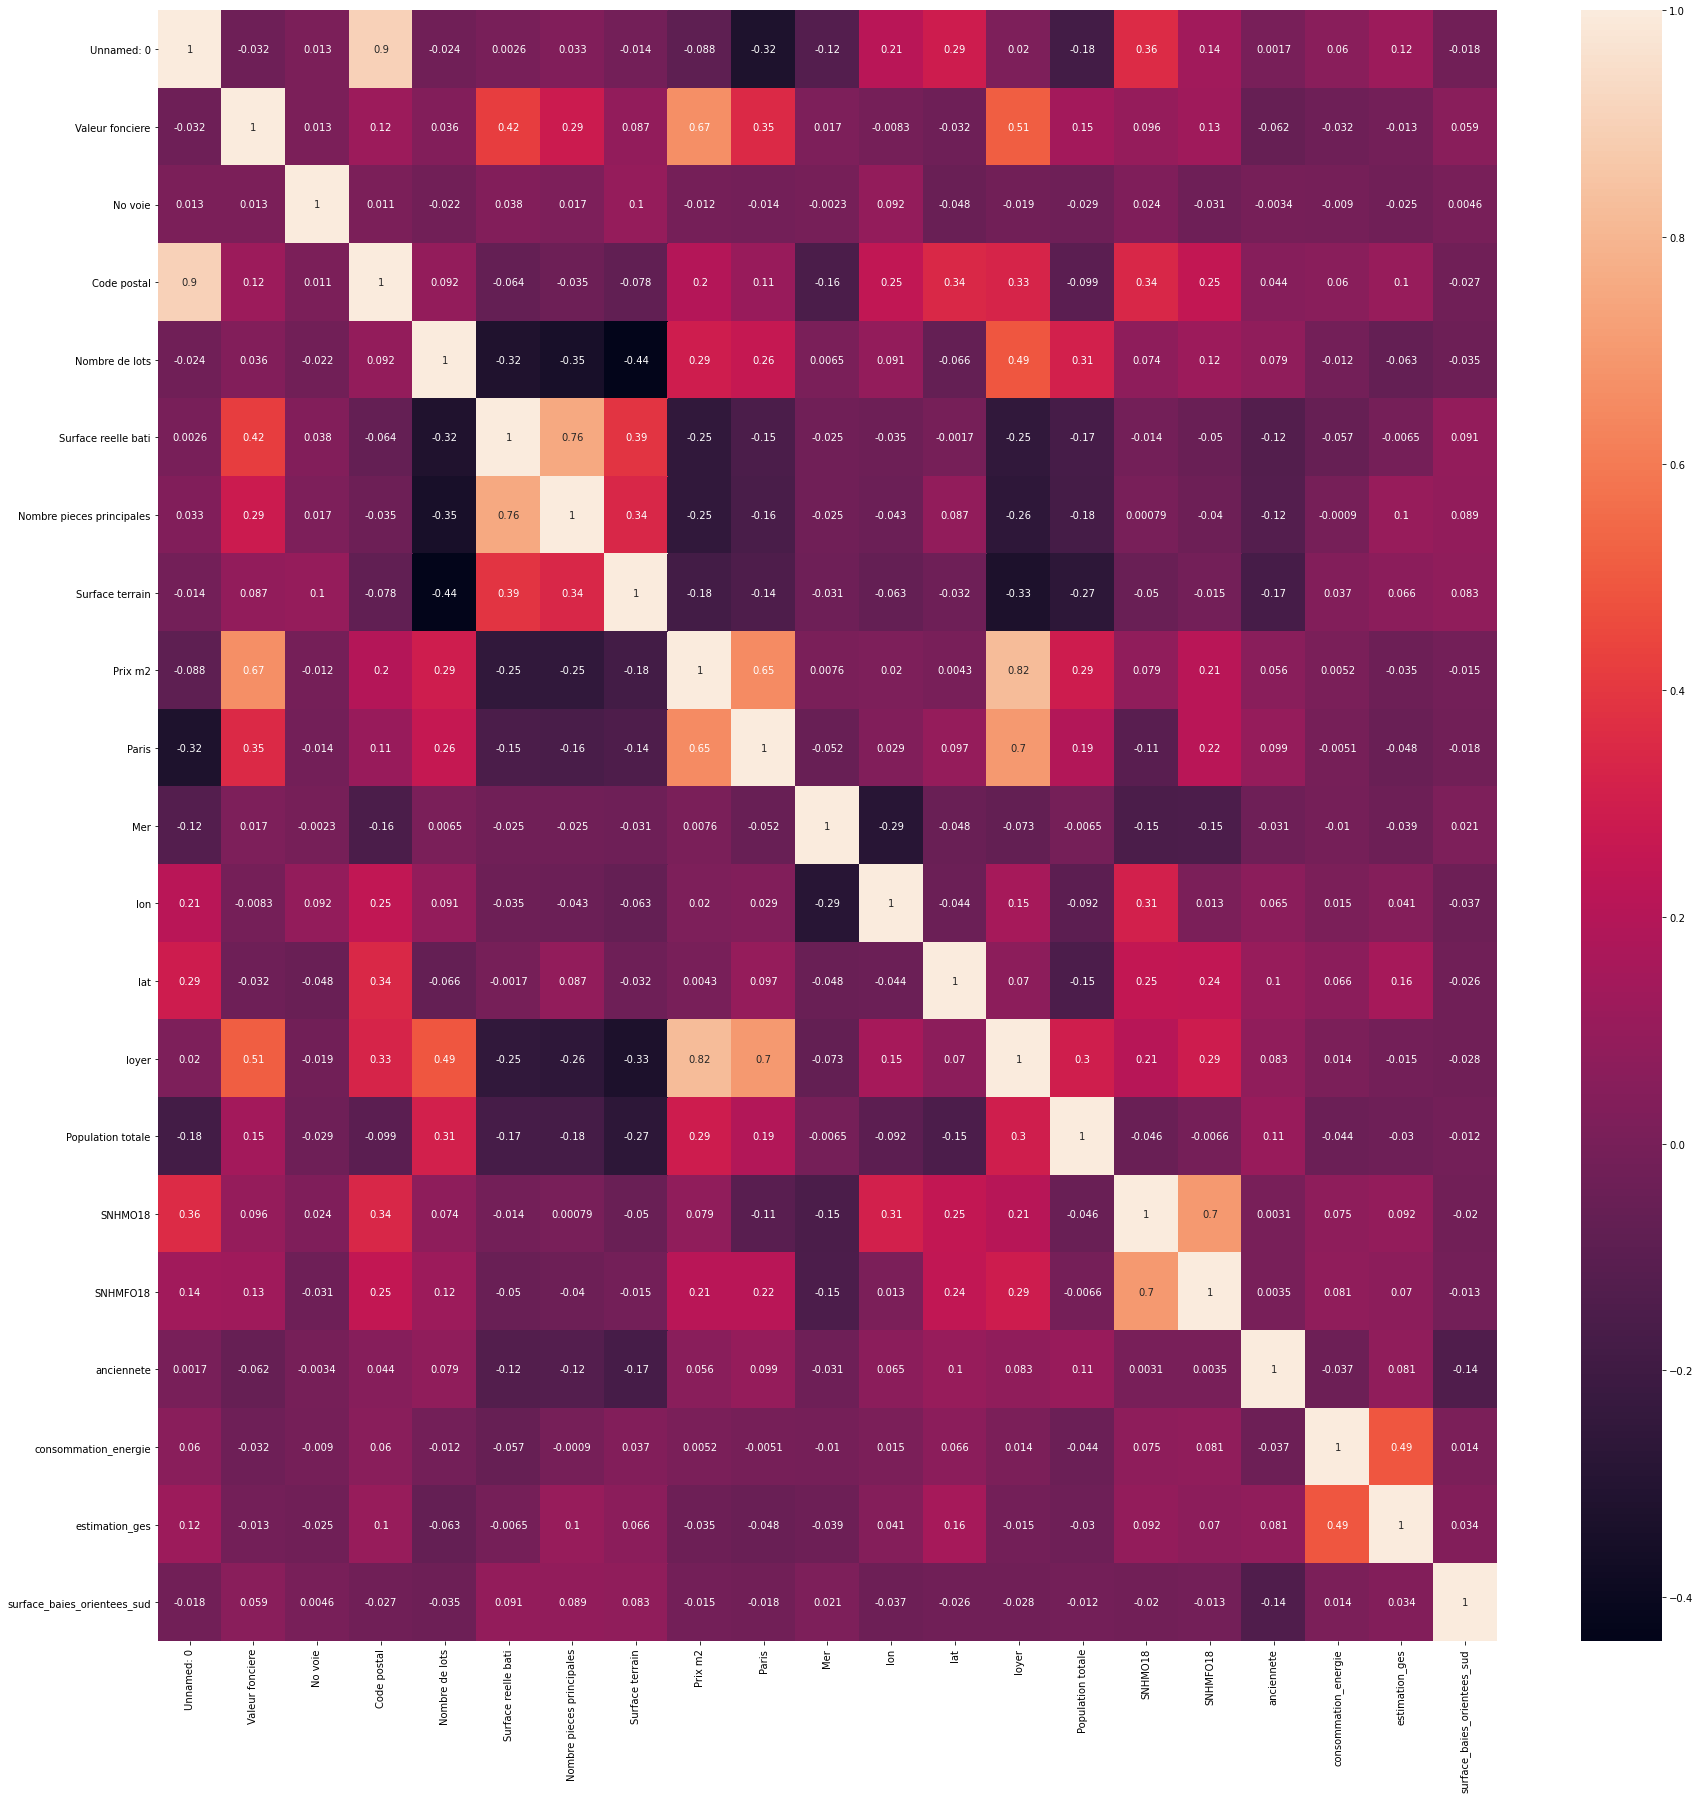

In [60]:
plt.figure(figsize = (30, 30))
matrice_correlation = merge_no_na.corr()
sns.heatmap(matrice_correlation, annot = True);